# 载入套件

In [1]:
from typing import Dict
from tqdm.auto import tqdm

import numpy as np
import random
import pandas as pd
import ydata_profiling

import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import torch
import os

%matplotlib inline

pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
sns.set_palette("RdBu")
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)


# 工具函数

In [2]:
SEED = 20230723


def same_seed(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


same_seed()


# 数据探索

## 辅助表格

app_class.csv，共两列。第一列是appid,给出4000多个常用APP所属类别（app_class）,比如：社交类、影视类、教育类等，用英文字母a-t表示，共20个常用得所属类别，其余APP不常用，所属类别未知。

In [3]:
# 辅助表格，常用APP类别
# 发现：原始表格存在重复值
app = pd.read_csv('../Datasets/app_class.csv', header=None).drop_duplicates()
app.columns = ['appid', 'app_class']

# 约束数据格式
app['appid'] = app['appid'].astype('category')
app['app_class'] = app['app_class'].astype('category')

# 打印行列数
print('app:', app.shape)


app: (4197, 2)


In [4]:
app.describe()


,appid,app_class
count,4197,4197
unique,4197,20
top,4,t
freq,1,1559


In [5]:
pd.DataFrame(app.value_counts('app_class'))


,count
app_class,
t,1559
g,386
i,232
c,196
f,156
j,155
h,152
q,143
b,141


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


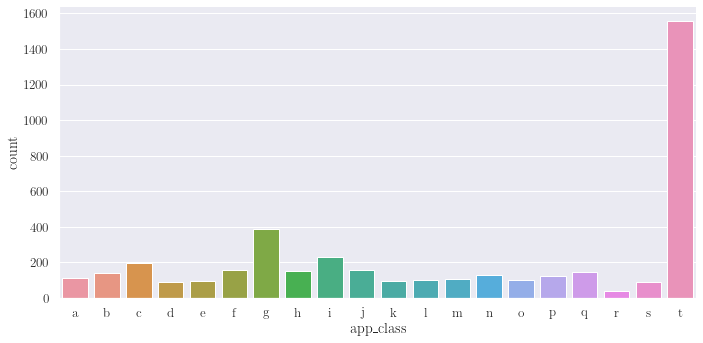

In [6]:
sns.catplot(kind='count', data=app, x='app_class', height=5, aspect=10/5)

plt.savefig("figures/app_class_countplot.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


## 监测表格

该数据来自某公司某年连续30天的4万多智能手机用户的监测数据，已经做了脱敏和数据变换处理。每天的数据为1个txt文件，共10列，记录了每个用户（以uid为唯一标识）每天使用各款APP（以appid为唯一标识）的起始时间，使用时长，上下流量等。

| 变量名        | 释义                          |
|------------|-----------------------------|
| uid        | 用户的id                       |
| appid      | APP的id（与app_class文件中的第一列对应） |
| app_type   | APP类型：系统自带、用户安装             |
| start_day  | 使用起始天，取值1-30                |
| start_time | 使用起始时间                      |
| end_day    | 使用结束天                       |
| end_time   | 使用结束时间                      |
| duration   | 使用时长（秒）                     |
| up_flow    | 上行流量                        |
| down_flow  | 下行流量                        |

### DAY01

根据用户常用所属的20类APP的数据对用户进行聚类，分析聚类结果。
根据聚类结果对不同类别的用户画像，并且分析不同群体用户的特征。

In [7]:
df = pd.read_pickle('../Datasets/day01_new.pkl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860124 entries, 0 to 5860123
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   uid             category      
 1   app_type        category      
 2   app_class       category      
 3   start_time_new  datetime64[ns]
 4   end_time_new    datetime64[ns]
 5   duration        int64         
 6   up_flow         int64         
 7   down_flow       int64         
dtypes: category(3), datetime64[ns](2), int64(3)
memory usage: 257.3 MB


In [8]:
# 发现：数据存在重复值
df[(df.duplicated(keep=False)) & (df['app_class'] != 'NaN')
   & (df['uid'] == '9BB8C3325CDB977A9411BEE3A8D3F06A')
   ]


,uid,app_type,app_class,start_time_new,end_time_new,duration,up_flow,down_flow
1797,9BB8C3325CDB977A9411BEE3A8D3F06A,usr,d,1900-01-01 02:22:27,1900-01-01 02:30:03,456,4818891,75173
1798,9BB8C3325CDB977A9411BEE3A8D3F06A,usr,d,1900-01-01 02:22:27,1900-01-01 02:30:03,456,4818891,75173


#### 类别特征

> 跨字段验证

In [9]:
df.select_dtypes('category').describe()


,uid,app_type,app_class
count,5860124,5860124,5860124
unique,35451,4,21
top,A9E4AAC5B8E05D2A4E35E0D4F2994F37,usr,NaN
freq,7335,3270732,2682179


In [10]:
# 发现：数据集存在中文['用户', '预装']
df.select_dtypes('category').describe()


,uid,app_type,app_class
count,5860124,5860124,5860124
unique,35451,4,21
top,A9E4AAC5B8E05D2A4E35E0D4F2994F37,usr,NaN
freq,7335,3270732,2682179


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


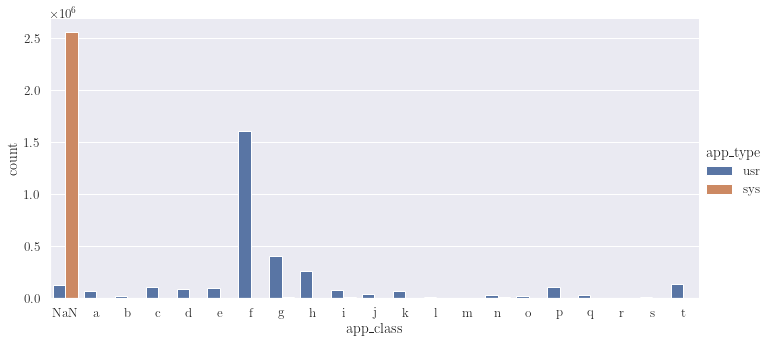

In [11]:
df.replace({'用户': 'usr', '预装': 'sys'}, inplace=True)
g = sns.catplot(kind='count', data=df, x='app_class',
                hue='app_type', hue_order=['usr', 'sys'], height=5, aspect=10/5)

plt.savefig("figures/app_class_day01_countplot_hue_on_type.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


In [12]:
# 发现：有‘僵尸用户’（请求/活跃程度极低，监控记录中app_class均为NaN）
df[df['uid'] == '3B0AAFBD3213D6DB0CCB17EDEAE80C38']


,uid,app_type,app_class,start_time_new,end_time_new,duration,up_flow,down_flow
0,3B0AAFBD3213D6DB0CCB17EDEAE80C38,sys,NaN,1899-12-31 20:43:27,1900-01-01 20:43:50,86423,0,0
1,3B0AAFBD3213D6DB0CCB17EDEAE80C38,sys,NaN,1899-12-31 20:43:27,1900-01-01 20:43:50,86423,0,0


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


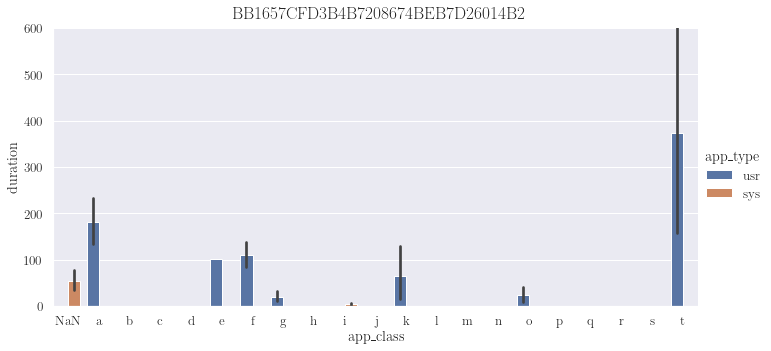

In [24]:
users = df[df['uid'].isin(
    ['BB1657CFD3B4B7208674BEB7D26014B2'])
]

g = sns.catplot(
    kind="bar",
    data=users,
    x='app_class',
    y='duration',
    hue='app_type',
    hue_order=['usr', 'sys'],
    height=5,
    aspect=10/5,
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('BB1657CFD3B4B7208674BEB7D26014B2')
g.set(
    ylim=[0, 600]
)

plt.savefig("figures/duration_class_day01_BB1657CFD3B4B7208674BEB7D26014B2_barplot_hue_on_type.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


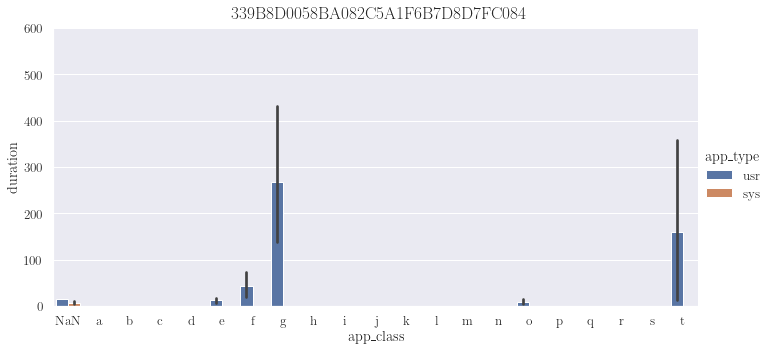

In [26]:
users = df[df['uid'].isin(
    ['339B8D0058BA082C5A1F6B7D8D7FC084'])
]

g = sns.catplot(
    kind="bar",
    data=users,
    x='app_class',
    y='duration',
    hue='app_type',
    hue_order=['usr', 'sys'],
    height=5,
    aspect=10/5,
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('339B8D0058BA082C5A1F6B7D8D7FC084')
g.set(
    ylim=[0, 600]
)

plt.savefig("figures/duration_class_day01_339B8D0058BA082C5A1F6B7D8D7FC084_barplot_hue_on_type.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


#### 数值特征

In [16]:
df.select_dtypes('number').describe()


,duration,up_flow,down_flow
count,5.860124e+06,5.860124e+06,5.860124e+06
mean,2.479844e+03,5.878114e+05,1.521328e+05
std,1.620907e+06,1.073372e+07,6.326323e+06
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+01,0.000000e+00,0.000000e+00
75%,3.600000e+01,1.201000e+03,1.025000e+03
max,1.427770e+09,3.639474e+09,3.292713e+09


In [17]:
df['duration'].min()


1

In [18]:
# 发现：有僵尸‘应用’（持续时间极长）
print("max_duration ", df['duration'].max()/60/60/24)
print("duration>10000 ", df.query('duration>43200').shape[0])
print("duration>43200 ", df.query('duration>43200').shape[0])
print("duration>86400 ", df.query('duration>86400').shape[0])
print("proportion ", df.query(
    'duration>86400').shape[0] / df.query("app_class == 'NaN'").shape[0])


max_duration  16525.11438657407
duration>10000  91
duration>43200  91
duration>86400  89
proportion  3.318197629613833e-05


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set(**kwargs)


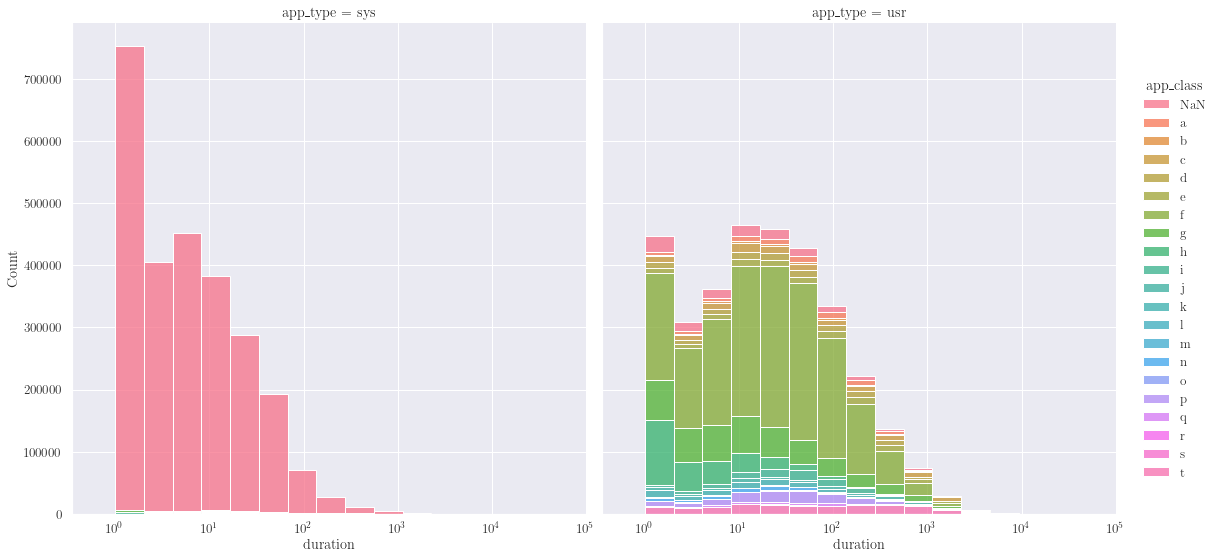

In [19]:
g = sns.displot(
    data=df,
    x='duration',
    log_scale=True,
    bins=30,
    hue='app_class',
    col='app_type',
    multiple="stack",
    height=8,
    aspect=1.0,
)

g.set(
    xlim=(0, 1e5)
)

plt.savefig("figures/duration_displot_hue_on_class.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


In [21]:
duration_agg_by_app = df.pivot_table(
    index='app_class',
    values='duration',
    aggfunc={
        'duration': [np.min, np.max, np.mean, np.std, np.sum],
    }
)

duration_agg_by_app = pd.DataFrame(
    duration_agg_by_app.to_records()).query("app_class != 'NaN'")


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


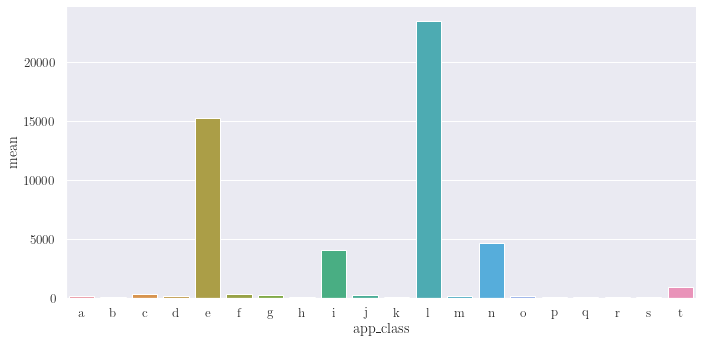

In [22]:
g = sns.catplot(kind='bar',
                data=duration_agg_by_app,
                x='app_class',
                y='mean',
                height=5,
                aspect=10/5)

plt.savefig("figures/duration_mean_agg_by_app.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


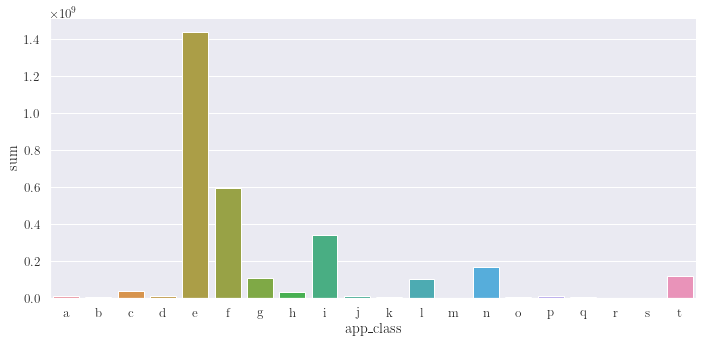

In [23]:
g = sns.catplot(kind='bar',
                data=duration_agg_by_app,
                x='app_class',
                y='sum',
                height=5,
                aspect=10/5)

plt.savefig("figures/duration_mean_agg_by_app.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


#### 序列特征

In [27]:
df.select_dtypes('datetime').describe()


,start_time_new,end_time_new
count,5860124,5860124
mean,1900-01-01 13:49:44.356820224,1900-01-01 14:31:04.303291392
min,1854-10-04 08:00:45,1900-01-01 00:00:00
25%,1900-01-01 10:35:49,1900-01-01 10:36:37
50%,1900-01-01 14:43:00,1900-01-01 14:43:49
75%,1900-01-01 18:46:10,1900-01-01 18:47:05
max,1900-01-01 23:59:59,1900-01-01 23:59:59


In [28]:
# 发现：有错误日志（开始时间大于结束时间）
df[df['start_time_new'] > df['end_time_new']].shape


(20, 8)

#### 数据直觉：降采样/聚合

- 无线局域网和蜂窝网络

- 屏幕使用时间报告
    - 周报
        - 总屏幕使用时长（日均）
        - 每日各类app总使用时长
        - 总通知/拿起次数（日均）
        - 每日各类app总通知/拿起次数
    - 日报
        - 粒度更细，屏幕使用时间与通知/拿起次数以小时为单位

APP所属类别可划分为：
1. 娱乐，如哔哩哔哩、腾讯视频、网易云音乐
2. 效率与财务，如钉钉、日历、备忘录、百度网盘
3. 社交，如QQ、微信、知乎
4. 旅行，如地图
5. 购物与美食，如淘宝、美团外卖
6. 信息与阅读，如天气
7. 创意，如相机、美图秀秀
8. 工具，如QQ邮箱、AppStore
9. 教育，如校园助手、DataCamp
10. 健康与健身，如Keep

##### 每类 app 的使用*总*时长

> TODO：对数变换，归一化

/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


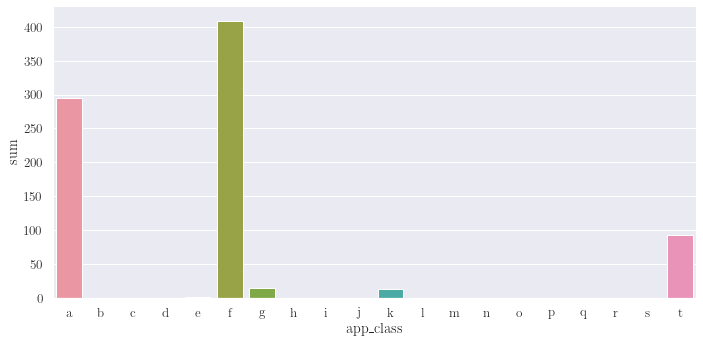

In [37]:
uid = 'BB1657CFD3B4B7208674BEB7D26014B2'
user = df.query('uid == @uid')

user_duration_agg_by_app = user.pivot_table(
    index='app_class',
    values='duration',
    aggfunc={
        'duration': [np.sum],
    }
)

user_duration_agg_by_app = pd.DataFrame(
    user_duration_agg_by_app.to_records()).query("app_class != 'NaN'")

user_duration_agg_by_app['sum'] = user_duration_agg_by_app['sum'].apply(
    lambda x: x//60)

g = sns.catplot(kind='bar',
                data=user_duration_agg_by_app,
                x='app_class',
                y='sum',
                height=5,
                aspect=10/5)

plt.savefig("figures/BB1657CFD3B4B7208674BEB7D26014B2_duration_agg_by_app.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


##### 每类 app 的活跃（拿起/通知）次数

/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


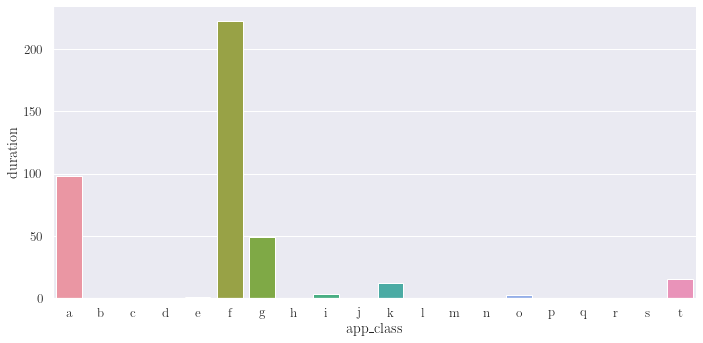

In [42]:
user_count_agg_by_app = user[['duration', 'app_class']
                             ].groupby(by='app_class').count()

user_count_agg_by_app = pd.DataFrame(
    user_count_agg_by_app.to_records()).query("app_class != 'NaN'")

g = sns.catplot(kind='bar',
                data=user_count_agg_by_app,
                x='app_class',
                y='duration',
                height=5,
                aspect=10/5)

plt.savefig("figures/BB1657CFD3B4B7208674BEB7D26014B2_count_agg_by_app.pdf",
            dpi=400, bbox_inches='tight', pad_inches=0.05)


##### 每类 app 的 24 小时 分布（使用时长）：代办

In [ ]:
# 添加代码


### DAY01-DAY21

> TODO：时间序列预测

- 根据用户第1~11天的**a类**APP的使用情况，来预测用户在第12~21天是否会使用该类APP。
- 根据用户第1~11天的**a类**APP的使用情况，来预测第12~21天用户使用a类APP的有效日均使用时长。

In [ ]:
# 添加代码
